# Zernike Fitting

In this notebook we will fit Zernike coefficients to measured point spread functions. 

In [56]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
#!pip install --upgrade pip
#!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
#!pip install git+https://github.com/TuragaLab/chromatix.git

In [13]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
from flax.training.train_state import TrainState
import numpy as np

import optax

import matplotlib.pyplot as plt

from chromatix.elements import ObjectivePointSource, FFLens, ZernikeAberrations
from chromatix.ops.noise import shot_noise
from chromatix.utils import trainable

from typing import Optional, Tuple

key = random.PRNGKey(42)

## Constructing the forward model 

First we need to model how Zernike coefficients affect the PSFs. This is done by calculating the Zernike aberrations from the coefficients (given as ANSI indices).

In [19]:
class ZernikePSF(nn.Module):
    ansi_indices: np.ndarray = np.arange(1, 11)
    camera_shape: Tuple[int, int] = (256, 256)
    camera_pixel_pitch: float = 0.125
    f: float = 100
    NA: float = 0.8
    n: float = 1.33
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    upsample: int = 4
    pad: int = 128
    taper_width: Optional[float] = 5

    @nn.compact
    def __call__(self):
        # Some preliminaries
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        spacing = self.upsample * self.f * self.wavelength / (self.n * shape[0] * self.camera_pixel_pitch)

        # Actual simulation
        # The only learnable parameters are the Zernike coefficients (since we use the trainable flag)
        field = ObjectivePointSource(shape, 
                                    spacing, 
                                    self.wavelength, 
                                    self.wavelength_ratio,
                                    self.f, 
                                    self.n, 
                                    self.NA, 
                                    power=1e7)(z=0)
        
        field = ZernikeAberrations(trainable(jnp.zeros_like(self.ansi_indices, dtype=jnp.float32)), 
                                    self.f, 
                                    self.n, 
                                    self.NA, 
                                    self.ansi_indices)(field)

        field = FFLens(self.f, self.n)(field)
        return field

Now, using the ZernikePSF forward model, let's generate a "measured" PSF for some "unknown" coefficients that we will ultimately like to learn.

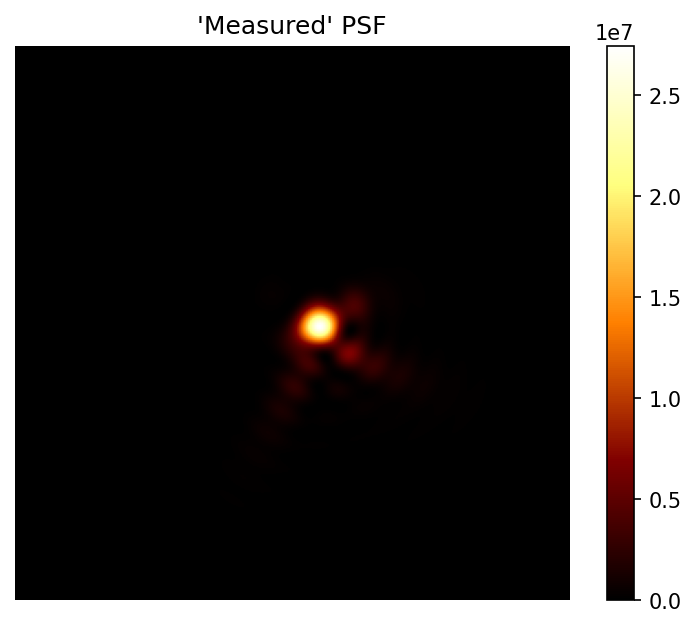

In [20]:
# Initialize model
model = ZernikePSF()

# Set "ground truth" parameters (which will eventually try to estimate)
coefficients_truth = jnp.array([2.0, 5.0, 3.0, 0, 1, 0, 1, 0, 1, 0])
params_truth = jax.tree_map(lambda x: coefficients_truth, model.init(key))

# Get the corresponding "measured" PSF using the true coefficients
psf_truth = model.apply(params_truth)
psf_truth = shot_noise(key, psf_truth.intensity)  # add shot noise

crop = 450
plt.figure(dpi=150)
plt.imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

## Learning Zernike Coefficients 

Now that we have our target PSF, we will learn its underlying Zernike coefficients by optimizing through the forward model. First let's define a few functions needed for the training.

In [21]:
# This loss function will be our metric for measuring how close our predicted PSF is to the measured PSF. For now we
# use mean squared error.
def loss_fn(params, data):
    psf_estimate = model.apply(params).intensity
    loss = jnp.mean((psf_estimate - data)**2) / jnp.mean(data**2)
    return loss, {"loss": loss}


# Setting the state which has the model, params and optimiser
state = TrainState.create(apply_fn=model.apply, 
                          params=model.init(key), 
                          tx=optax.adam(learning_rate=0.5))

# Defining the function which returns the gradients
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True))


Now its time to learn! We using our forward model and the optimization parameters/functions specified above we will
learn the coefficients that correspond to a PSF that best matches our measured PSF. First we display our initial guess.

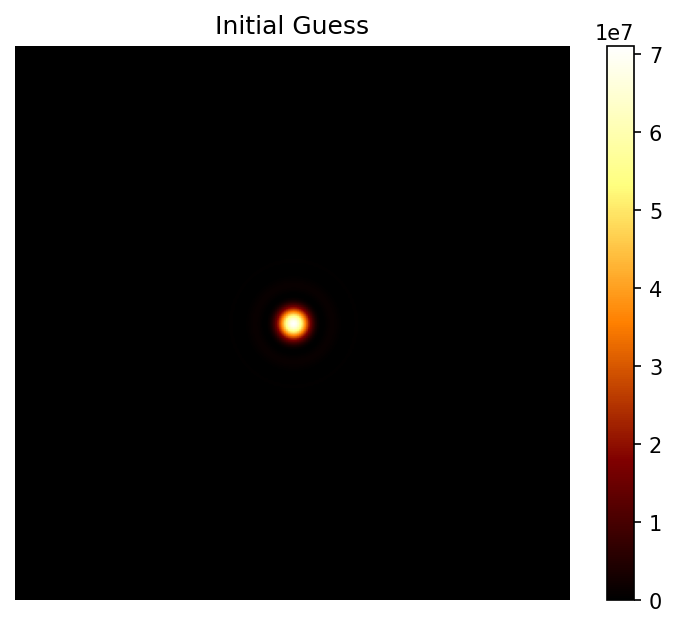

In [22]:
psf_init = state.apply_fn(state.params).intensity.squeeze()

plt.figure(dpi=150)
plt.imshow(psf_init[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title('Initial Guess')
plt.axis("off")
plt.show()

Below is the optimization loop:

In [23]:
%%time
# Simple training loop
max_iterations = 500
for iteration in range(max_iterations):
    grads, metrics = grad_fn(state.params, psf_truth) 
    state = state.apply_gradients(grads=grads)

    if iteration % 100 == 0:
        print(iteration, metrics)


0 {'loss': Array(3.7028666, dtype=float32)}
100 {'loss': Array(0.04931437, dtype=float32)}
200 {'loss': Array(8.5801e-06, dtype=float32)}
300 {'loss': Array(1.1201623e-07, dtype=float32)}
400 {'loss': Array(1.1192892e-07, dtype=float32)}
CPU times: user 1min 14s, sys: 9.36 s, total: 1min 24s
Wall time: 41.7 s


Let's see how well we did!

Estimated coefficients: [2.0000355e+00 5.0000520e+00 3.0001011e+00 6.6425549e-05 1.0000430e+00
 6.1772866e-05 1.0000404e+00 4.7390826e-05 1.0001092e+00 1.9684526e-04]
Coefficients error: [1.26198074e-09 2.70142664e-09 1.02190825e-08 4.41235359e-09
 1.85197280e-09 3.81588672e-09 1.63312563e-09 2.24589036e-09
 1.19237029e-08 3.87480554e-08]
Mean coefficients error: 7.881348e-09


Text(0, 0.5, 'Estimation error')

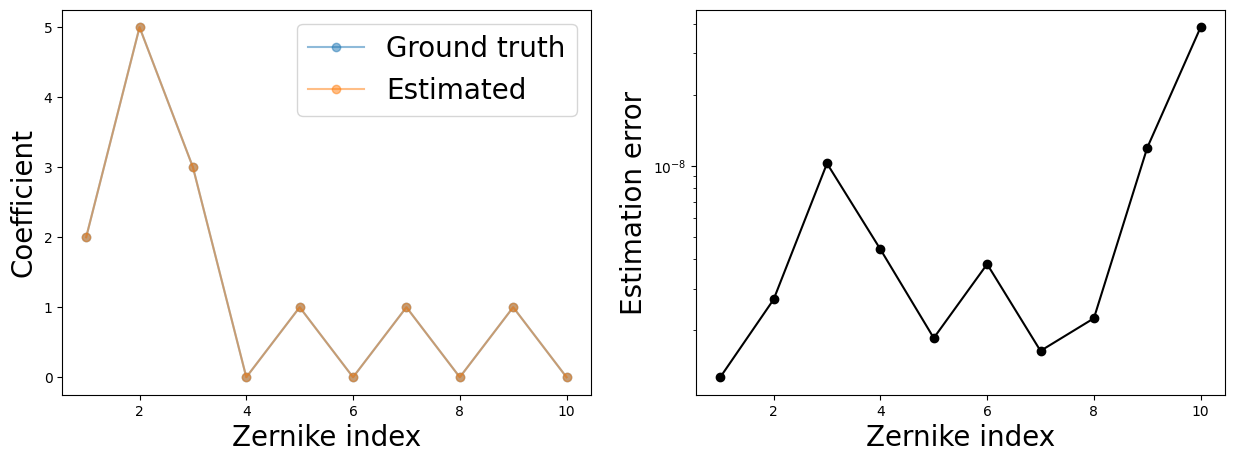

In [24]:
# Our final predicted coefficients
coefficients_estimated = jnp.abs(state.params["params"]["ZernikeAberrations_0"]["zernike_coefficients"])
print("Estimated coefficients:", coefficients_estimated)

coefficients_error = (coefficients_estimated - coefficients_truth)**2
print("Coefficients error:", coefficients_error)

mean_coefficients_error = jnp.mean((coefficients_estimated - coefficients_truth)**2)
print("Mean coefficients error:", mean_coefficients_error)

# Plots of ground truth, estimates and errors
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fontsize = 20
ax[0].plot(model.ansi_indices, coefficients_truth, "-o", label="Ground truth", alpha=0.5)
ax[0].plot(model.ansi_indices, coefficients_estimated, "-o", label="Estimated", alpha=0.5)
ax[0].set_xlabel("Zernike index", fontsize=fontsize)
ax[0].set_ylabel("Coefficient", fontsize=fontsize)
ax[0].legend(fontsize=fontsize)
ax[1].semilogy(model.ansi_indices, coefficients_error, "k-o")
ax[1].set_xlabel("Zernike index", fontsize=fontsize)
ax[1].set_ylabel("Estimation error", fontsize=fontsize)

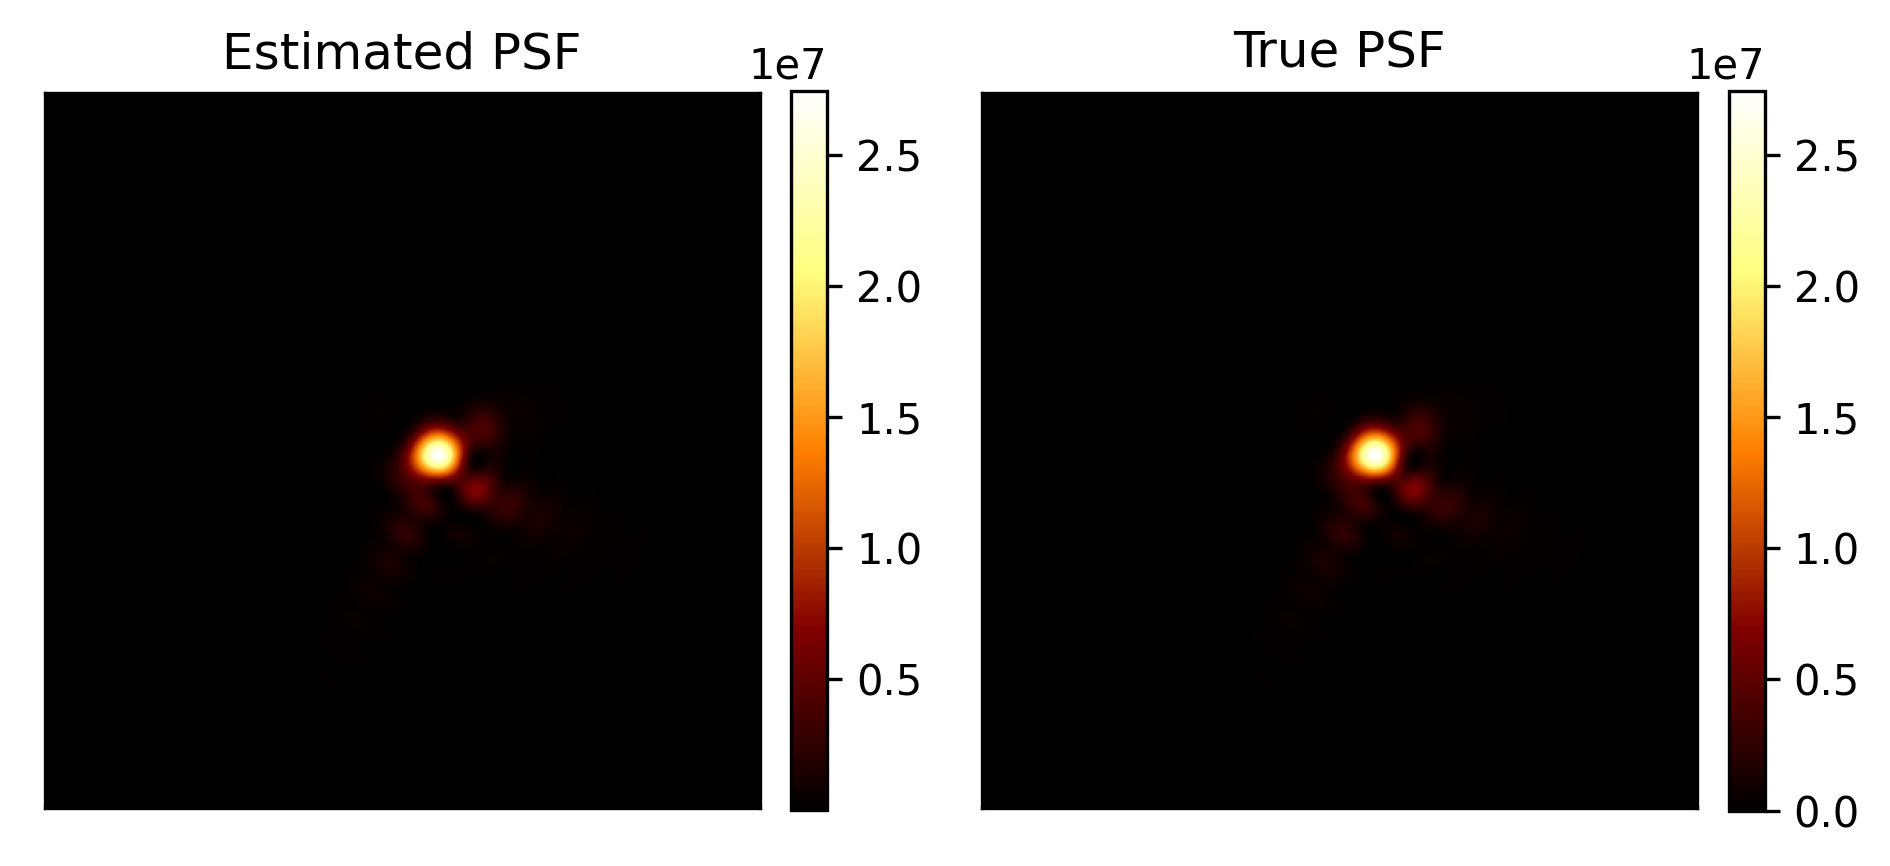

In [25]:
psf_estimated = state.apply_fn(state.params).intensity.squeeze()

fig, ax = plt.subplots(1, 2, dpi=300)
m = ax[0].imshow(psf_estimated[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[0].title.set_text("Estimated PSF")
m = ax[1].imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[1].title.set_text("True PSF")
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()